In [2]:
import qiskit
import numpy as np

In [3]:
""" 
    Quantum algorithms: Grover’s search algorithm
    http://dkopczyk.quantee.co.uk/grover-search/
    
    Qiskit
    https://qiskit.org/documentation/getting_started.html
    https://qiskit.org/textbook/ch-algorithms/grover.html
"""
from qiskit import(
  QuantumCircuit,
  execute,
  Aer)
from qiskit.visualization import plot_histogram

# |x, y> => |x, y ⊕ f(x)>
# y = (|0> - |1>)/√2 (或是寫成 |->)
# => |x> ⊗ (|0 ⊕ f(x)> - |1 ⊕ f(x)>) /√2 
# binary XOR 跟 NOT 一樣
# => |x> ⊗ (|f(x)> - |not f(x)>) /√2 
# x = 0,  |x>|y>  (+ 正的)
# x = 1, -|x>|y>  (- 負的)
# 寫成一起: (-1)^f(x) |x>|y>
# x = (|0> + |1>)/√2

Result are: {'001': 1024}


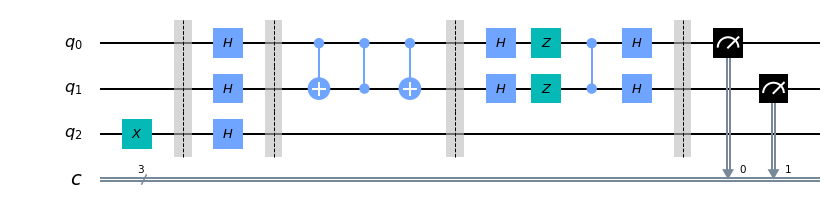

In [7]:
# Grover’s search algorithm
# f:{0,1}n -> {0, 1} 
# 有個黑盒子只會在 x = x0 的時候才會 return 1
# 一開始會產生所有可能的疊加態
# 每個 iteration 增加答案的可能性

simulator = Aer.get_backend('qasm_simulator')

# 2 個 qubit 當輸入可能， 1 個 control qubit
circuit = QuantumCircuit(3, 3)

circuit.x(2) #(=Not gate) 讓 qubit 2 (第三個) 的輸入是 1 (control qubit)
circuit.barrier()
circuit.h([0, 1, 2]) # 0~2 都放上 H gates
circuit.barrier()

# Uf 的部分 (Quantum Oracle)
# 如同 DOIGE -> 是 0 的都會是正號
# (-1)^f(x) |x>|y>
# 所以 apply Uf 之後目標會變成負號，其他人不動 
# 四種情況
# 1: 00[1000] ->  00
# 2: 01[0100] ->  01
# 3: 10[0010] -> -10
# 4: 11[0001] ->  11
# 所以理論上 Uf 如下
# [1 0  0 0]
# [0 1  0 0]
# [0 0 -1 0]
# [0 0  0 1]

# cx, (CNot) 如下
# [1 0 0 0]
# [0 1 0 0]
# [0 0 0 1]
# [0 0 1 0]
# [0010] -> [0001] (|10> => |11>)
# cz
# [1 0 0  0] 
# [0 1 0  0]
# [0 0 1  0]
# [0 0 0 -1]
# [0001] -> -[0001] (|11> => -|11>)
# cx
# [1 0 0 0]
# [0 1 0 0]
# [0 0 0 1]
# [0 0 1 0]
# -[0001] -> -[0010] (-|11> => -|10>)

# 這邊假設 2 個 bit, x = "10" 才會 return 1
circuit.cx(0, 1) #其實只要對第二個 qubit apply not 就好, x(1)
circuit.cz(0, 1) #|11> to -|11>
circuit.cx(0, 1)
circuit.barrier()

""" Oracle Uf
兩個 qubit
    |11>:
        藉由 Controlled-Z: 只 |11> 變 -|11>
        1/2(|00> + |01> + |10> + |11>)
        cz(0, 1)
        => 1/2(|00> + |01> + |10> - |11>)
    |00>:
        反轉 cz
        兩個都接 X 來反轉 input
        x(0), x(1)
        => 1/2(|11> + |10> + |01> + |00>)
        cz(0, 1)
        => 1/2(-|11> + |10> + |01> + |00>)
        X 反轉回來
        x(0), x(1)
        => 1/2(-|00> + |01> + |10> + |11>)
    |01>, |10>:
        只反轉第一個 qubit 或第二個 qubit
        ex: |01>
        x(0)
        => 1/2(|10> + |11> + |00> + |01>)
        通過 cz(0, 1)
        => 1/2(|10> - |11> + |00> + |01>)
        轉回去 x(0)
        => 1/2(|00> - |01> + |10> + |11>)

"""


#Reflection Us = H (2 |0^n><0^n| - I) H
#整個算起來 = 1/2[
# [-1 1 1 1]
# [1 -1 1 1]
# [1 1 -1 1]
# [1 1 1 -1]
#]
#簡單點來看 H 可以直接加在電路上 -> 只要實作 (2 |0^n><0^n| - I)
# [ 1 0 0 0]
# [0 -1 0 0]
# [0 0 -1 0]
# [0 0 0 -1]
# 發現不改變 |00> 的 sign，其他都負號
# z gate 只會讓 |1> 變 -|1>
circuit.h(0)
circuit.h(1)

circuit.z(0) #第一個 qubit 有 1 變號
circuit.z(1) #第二個 qubit 有 1 變號
circuit.cz(0, 1) # 讓 (-|1>-|1>) = |11> 變成 -|11>

circuit.h(0)
circuit.h(1)
circuit.barrier()

"""
所以到底要做幾個 iteration (apply G 總共 t 次)? 
    N = 兩個 qubit 2^2 = 4 
    θ = arc( sin( sqrt(1) / sqrt(4) ) ) = arc (sin ½) = π/6 (30度) 
    當 t steps => sin θt |w> + cos θt |s’>, 
    => where θt = (2t + 1)θ
    
    目標是 θt = π/2 (90 度) 
    所以 t = 1
    
    簡單來說約等於: π/4 * sqrt(N) 
    
    N = 8 -> 20.7度左右
"""


# Map the quantum measurement to the classical bits
circuit.measure([0, 1], [0, 1])

# Execute the circuit on the qasm simulator
job = execute(circuit, simulator)

# Grab results from the job
result = job.result()

# Returns counts
counts = result.get_counts(circuit)
print("Result are:",counts)

# Draw the circuit
circuit.draw(output='mpl')
# 順序 q2, q1, q0, ...
# 答案確實為 10 (q0, q1)